In [1]:
import numpy as np, pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [2]:
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1"   # set before importing numpy/xgboost
os.environ["MKL_NUM_THREADS"] = "1"

classes_path = os.path.abspath(r"D:\Repositories\PhD\src\classes")
src_path = os.path.abspath(r"D:\Repositories\PhD\src\functions")
sys.path.append(src_path)
sys.path.append(classes_path)
print(sys.path)

import hht_fe
import helpers
import AD_Mahalanobis_Cluster as admc

['d:\\Anaconda\\envs\\ml-cpu\\python311.zip', 'd:\\Anaconda\\envs\\ml-cpu\\DLLs', 'd:\\Anaconda\\envs\\ml-cpu\\Lib', 'd:\\Anaconda\\envs\\ml-cpu', '', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32\\lib', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\Pythonwin', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes']


In [3]:
def extract_features(X_healthy, X_faulty, fs, shuffle = True, win_s = 0.2, step_s=0.05, k_target=6):
    
    hht_fe_class = hht_fe.HHT_FeatureExtraction()

    if isinstance(X_healthy, pd.Series):
        X_healthy, names_healthy = hht_fe_class.windowed_hht_table(X_healthy.values, fs, win_s=win_s, step_s=step_s, k_target=k_target)
    else:
        X_healthy, names_healthy = hht_fe_class.windowed_hht_table(X_healthy, fs, win_s=win_s, step_s=step_s, k_target=k_target)
    df_healthy = pd.DataFrame(data=X_healthy, columns=names_healthy)
    if isinstance(X_faulty, pd.Series):
        X_faulty, names_faulty = hht_fe_class.windowed_hht_table(X_faulty.values, fs,win_s=win_s, step_s=step_s, k_target=k_target)
    elif isinstance(X_faulty, np.ndarray):
        X_faulty, names_faulty = hht_fe_class.windowed_hht_table(X_faulty, fs,win_s=win_s, step_s=step_s, k_target=k_target)
    df_faulty = pd.DataFrame(data=X_faulty, columns=names_faulty)

    df_healthy['baseline'] = 1
    df_healthy['fault'] = 0
    df_faulty['baseline'] = 0
    df_faulty['fault'] = 1
    df_overall = pd.concat((df_healthy,df_faulty))
    df_overall = df_overall.reset_index(drop=True)
    if shuffle:
        df_overall = df_overall.sample(frac = 1) # shuffle df

    return df_overall

In [4]:
df = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv")
df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


In [5]:


de_healthy = df[(df['fault_end'] == 0) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 0) & (df['fault_diameter'] == 0)]['DE']
de_faulty = df[(df['fault_end'] == 1) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 1) & (df['fault_diameter'] == 7)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

df_features = extract_features(de_healthy, de_faulty, fs = 12000)
df_features

(485643,)
(366988,)


,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
501,0.033011,2.905078,1.857814,-0.007154,0.349729,0.045337,0.011424,0.063278,2065.993850,235.385031,...,1035.0,18.219937,1065.0,17.217719,30.0,9.210088,1010.0,9.071178,1,0
275,0.032007,2.492539,1.830069,-0.004826,0.350563,0.043819,0.010530,0.062085,2076.642239,213.427594,...,1035.0,17.703634,1065.0,13.134676,30.0,10.280095,1095.0,9.204026,1,0
1257,0.764305,3.780786,4.071670,0.013447,0.454356,0.932694,0.577343,2.177801,2699.331599,197.269328,...,105.0,407.110810,205.0,303.584228,150.0,287.446766,100.0,215.533162,0,1
643,0.032907,3.562593,1.963809,0.025630,0.347228,0.044987,0.011877,0.063124,2050.896196,262.818142,...,1065.0,18.441579,1035.0,17.588972,30.0,13.516113,1010.0,9.145009,1,0
1014,0.258086,6.320653,8.010633,0.003364,0.557732,0.263278,0.244284,0.837157,3296.664993,354.543105,...,105.0,168.717515,45.0,139.257043,205.0,98.672320,310.0,82.749454,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0.032397,2.999435,1.884215,0.001198,0.348479,0.044546,0.011173,0.062421,2061.627108,243.970947,...,1065.0,17.840778,1035.0,15.108024,1095.0,10.144844,1040.0,9.388980,1,0
41,0.034516,4.169743,2.666729,0.118872,0.345977,0.046084,0.015756,0.066882,2006.191930,348.414080,...,1035.0,15.069014,30.0,12.429114,1065.0,11.564506,25.0,8.155728,1,0
769,0.031874,2.834727,1.820705,0.014103,0.348895,0.043704,0.010062,0.058836,2071.406248,254.307920,...,1035.0,16.097540,1065.0,12.718206,1040.0,11.560118,30.0,10.177872,1,0
127,0.032031,2.777817,1.780530,0.000393,0.350146,0.044131,0.010022,0.060197,2084.497179,195.859449,...,1035.0,17.839027,1065.0,15.165054,30.0,7.971999,1010.0,7.938511,1,0


In [6]:
df_features

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
1055,0.260696,5.790152,7.842451,0.017699,0.552730,0.266235,0.245998,0.850493,3288.552477,334.783874,...,105.0,154.749853,55.0,114.809193,45.0,105.794719,310.0,93.770596,0,1
527,0.033017,4.489761,2.636303,0.068072,0.348062,0.043732,0.012035,0.062299,2062.172854,263.806909,...,1035.0,16.044784,1065.0,14.853492,30.0,12.617569,1040.0,10.406439,1,0
1284,0.814465,3.649523,4.167785,0.027725,0.449354,0.964519,0.629856,2.342333,2694.425911,200.652093,...,105.0,470.310236,115.0,343.744124,205.0,323.248021,150.0,320.197827,0,1
670,0.032560,3.145893,1.912368,-0.001784,0.349729,0.044530,0.011640,0.063002,2063.379722,245.216119,...,1035.0,17.985210,1065.0,16.691442,30.0,9.396658,60.0,7.916228,1,0
1272,0.785670,3.682623,4.117310,0.014824,0.450604,0.928017,0.572942,2.106786,2694.100583,202.743285,...,105.0,435.367577,205.0,287.889264,115.0,286.385264,150.0,281.830138,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,0.034514,4.719301,2.794724,0.052367,0.348062,0.046572,0.015633,0.066109,2017.712538,330.713108,...,1035.0,18.334864,1065.0,16.874547,30.0,14.808386,55.0,11.844317,1,0
484,0.033027,3.642774,2.061069,0.052181,0.348062,0.044930,0.012539,0.064213,2042.671980,285.146357,...,1035.0,17.834615,1065.0,13.313698,30.0,13.181906,1045.0,8.222124,1,0
558,0.033403,3.567575,2.267287,0.035587,0.346811,0.045396,0.013373,0.064319,2033.748011,305.819357,...,1035.0,17.186193,1065.0,16.964310,30.0,14.849203,1010.0,8.836427,1,0
340,0.034161,4.582300,2.338529,0.033573,0.348479,0.046190,0.013779,0.064648,2043.316814,277.648363,...,1035.0,17.535636,1065.0,17.415797,1095.0,10.532366,55.0,9.207509,1,0


In [37]:
test_index = df_features[df_features['baseline']==1].sample(frac=0.2).index
test_index

Index([324, 202, 329, 429, 203, 576, 259, 386, 164, 605,
       ...
       475, 135, 591, 356, 631, 331, 496, 274, 145, 407],
      dtype='int64', length=161)

In [38]:
df_features.loc[test_index, 'baseline'] = 0
df_features

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak1_amp,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline
240,0.251807,5.540322,8.369145,-0.023000,0.554398,0.261736,0.248782,0.844997,3300.980795,336.340426,...,636.588950,105.0,151.462827,45.0,104.175888,30.0,94.771379,60.0,90.756029,0
219,0.032757,5.002292,2.257034,-0.045662,0.349312,0.044697,0.012217,0.061389,2063.523524,248.474503,...,150.895002,30.0,15.614827,1065.0,14.948056,1035.0,14.803579,1040.0,10.380602,1
380,0.033240,3.492454,2.055223,0.032490,0.348895,0.045511,0.012585,0.064125,2044.568050,293.809651,...,150.899920,1065.0,18.887284,1035.0,18.059337,30.0,16.826621,25.0,9.155408,1
541,0.800471,3.944297,4.151135,0.015613,0.448937,0.949305,0.591832,2.160819,2689.208641,204.954883,...,2303.679901,105.0,469.514004,205.0,328.177029,150.0,302.829885,115.0,273.208890,0
405,0.491651,5.475042,9.374355,-0.014675,0.523968,0.473587,0.518965,1.557957,2937.727921,397.795190,...,1142.633179,5.0,428.150326,100.0,265.464151,10.0,247.043881,95.0,171.115956,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.580235,4.899604,7.602585,0.056704,0.548145,0.557432,0.604208,1.921690,3243.562426,424.702815,...,1338.874647,105.0,554.815395,205.0,331.579559,310.0,312.925516,100.0,257.085665,0
17,0.035112,4.346180,2.830397,-0.004660,0.345144,0.047321,0.016141,0.067319,2006.684155,341.296028,...,150.347336,1035.0,16.486104,1065.0,14.535915,30.0,13.980808,25.0,9.185763,1
249,0.260696,5.790152,7.842451,0.017699,0.552730,0.266235,0.245998,0.850493,3288.552477,334.783874,...,659.240120,105.0,154.749853,55.0,114.809193,45.0,105.794719,310.0,93.770596,0
313,0.239531,6.878618,9.679060,-0.043068,0.557732,0.251108,0.237922,0.756152,3295.011763,341.380997,...,603.519046,105.0,139.579694,55.0,112.834750,100.0,96.767838,45.0,90.158461,0


In [39]:
df_features.loc[test_index, 'baseline']

324    0
324    0
202    0
202    0
329    0
      ..
274    0
145    0
145    0
407    0
407    0
Name: baseline, Length: 294, dtype: int64

In [66]:
df_train = df_features.sample(1000)

In [67]:
df_train

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
74,0.033417,3.472701,1.980950,0.008017,0.348479,0.045799,0.012298,0.064833,2054.094824,260.020095,...,1065.0,14.506605,1035.0,14.485434,30.0,12.125792,5.0,8.024554,1,0
1091,0.243276,5.743095,7.773683,0.008202,0.553981,0.265137,0.230090,0.783284,3297.021105,340.203697,...,105.0,158.109437,55.0,97.857557,100.0,92.712741,205.0,91.850742,0,1
599,0.033604,4.465764,2.376662,-0.035938,0.345561,0.045350,0.013922,0.066108,2023.859248,324.978448,...,1035.0,15.963803,1065.0,13.986873,30.0,12.966642,1040.0,7.653914,1,0
1374,0.803751,3.953149,4.014537,0.000445,0.449354,0.953580,0.600236,2.224345,2692.793762,199.207848,...,105.0,449.730316,205.0,306.240564,150.0,285.582775,115.0,249.146490,0,1
1265,0.789316,3.682569,4.140101,0.019398,0.448103,0.947779,0.594983,2.259346,2688.617737,206.392537,...,105.0,436.049411,150.0,306.332088,205.0,293.828395,115.0,288.153769,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,0.585350,4.595679,7.352146,-0.015575,0.546895,0.565259,0.603771,1.947466,3235.489632,416.406044,...,105.0,553.225518,205.0,328.832629,310.0,307.667265,100.0,255.368446,0,1
629,0.035650,3.839417,2.462263,0.008471,0.341809,0.048158,0.015665,0.072215,1978.014787,372.343510,...,1065.0,18.801125,1035.0,15.784931,30.0,12.327111,1350.0,7.222201,1,0
1107,0.252182,6.073161,8.377372,-0.017750,0.554398,0.264068,0.249235,0.837060,3282.408040,345.352561,...,105.0,149.443363,45.0,120.943562,60.0,101.932066,205.0,89.691871,0,1
412,0.032522,2.493430,1.829198,0.003717,0.350980,0.044778,0.010599,0.063575,2078.681815,207.682957,...,1035.0,18.926707,1065.0,14.368286,1010.0,10.374209,30.0,9.873939,1,0


In [69]:
df_test = df_features.drop(df_train.index)

In [80]:
df_test['baseline'] = 0
df_test

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
870,0.582974,5.068024,7.969544,0.041124,0.545644,0.571647,0.613397,1.969995,3240.969549,423.631188,...,105.0,559.146085,205.0,315.660671,310.0,315.162657,100.0,248.319870,0,1
63,0.032644,3.426610,1.925798,-0.001305,0.347645,0.044532,0.011161,0.061754,2057.955985,272.110553,...,30.0,19.255794,1035.0,17.003752,1065.0,14.080612,1040.0,8.387375,0,0
71,0.034559,4.422736,2.968271,0.132383,0.347228,0.046473,0.016182,0.065879,2015.493282,332.993939,...,1065.0,17.055445,1035.0,16.369466,30.0,14.354940,25.0,10.010260,0,0
1214,0.780680,3.448031,3.756231,0.020919,0.453522,0.927399,0.574883,2.133788,2697.046576,206.374356,...,105.0,416.270161,205.0,308.844476,115.0,282.555608,150.0,281.367845,0,1
174,0.032639,3.348354,2.022465,0.038566,0.347228,0.044520,0.011912,0.063978,2042.088407,296.284224,...,1035.0,16.389592,1065.0,15.367401,30.0,11.966398,1040.0,8.411645,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.033482,5.336576,2.729754,-0.021225,0.346811,0.045147,0.014082,0.061825,2032.932860,312.994776,...,1065.0,19.539854,1035.0,15.868444,1095.0,13.173354,30.0,12.932355,0,0
841,0.558727,5.154893,7.770458,-0.038933,0.556065,0.551032,0.585766,1.885391,3229.370397,456.452096,...,105.0,524.949401,205.0,325.826335,310.0,299.910629,100.0,259.761370,0,1
1087,0.248729,5.800791,8.648965,0.016853,0.556482,0.263092,0.244241,0.802867,3294.813588,338.864962,...,105.0,157.138421,45.0,110.955685,65.0,85.696343,310.0,84.929749,0,1
1344,0.768567,4.070682,4.104387,-0.001351,0.449354,0.934232,0.579410,2.151804,2695.153920,201.689165,...,105.0,453.463723,205.0,297.215431,150.0,286.713026,100.0,220.306335,0,1


In [81]:
f_cols = df_train.columns[:-2]

In [82]:
cfg = admc.PCAMahalanobisConfig(
        n_components=3,      # auto-select k to reach var_target
        var_target=0.95,
        standardize=True,
        robust=True,            # MinCovDet for baseline covariance
        q_ok=0.90,
        q_warn=0.99,
        baseline_col="baseline",
        baseline_value=1,
        cluster_mode = 'kmeans',
        kmeans_space = 'scores',
        feature_cols=f_cols       # infer numeric columns except 'label'; or pass an explicit list
    )

clf = admc.PCAMahalanobisClassifier(cfg)
result = clf.fit_predict(df_train)

# 'result' includes PC scores, md2 (squared Mahalanobis), md, and 'State' in {"Baseline","OK","Warning","Error"}.
# Example:
print(clf.thresholds())     # (t_ok, t_warn) on chi-square d^2 scale
print(result[["md2","State"]].head())

# If you need the PCA loadings:
loadings = clf.components_()

(None, None)
              md2     State
74       4.620110  Baseline
1091   945.485730        OK
599      1.299936  Baseline
1374  2326.270030   Warning
1265  2320.178110   Warning


d:\Anaconda\envs\ml-cpu\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [83]:
result

,PC1,PC2,PC3,md2,md,State
74,-5.765054,-1.789110,-0.417689,4.620110,2.149444,Baseline
1091,5.156592,-5.772235,2.898711,945.485730,30.748752,OK
599,-5.771823,0.974408,0.204354,1.299936,1.140147,Baseline
1374,7.058276,-2.031718,-4.918722,2326.270030,48.231422,Warning
1265,6.989661,-0.947030,-4.941994,2320.178110,48.168227,Warning
...,...,...,...,...,...,...
931,8.787210,0.106679,0.112324,2155.004875,46.422030,Error
629,-5.823042,3.715738,-0.375427,7.102910,2.665128,Baseline
1107,4.655585,-7.373478,2.400455,884.292327,29.737053,OK
412,-5.483525,0.037776,-0.082083,0.269951,0.519568,Baseline


In [84]:
test_result = clf.transform(df_test)
test_result['State'] = clf.predict(df_test)

In [85]:
test_result

,PC1,PC2,PC3,md2,md,State
870,10.762906,1.812634,0.736770,2731.156484,52.260468,Error
63,-5.377051,-1.053471,0.111682,1.709260,1.307387,OK
71,-5.258186,0.364832,0.666315,1.063473,1.031248,OK
1214,7.158589,-2.580817,-4.575441,2297.572212,47.932997,Warning
174,-6.096348,1.311243,-0.317987,2.677732,1.636378,OK
...,...,...,...,...,...,...
115,-5.175727,-0.318982,0.381967,0.989788,0.994881,OK
841,9.881359,7.829260,2.268536,2360.119539,48.581062,Error
1087,4.892314,-6.664273,2.864637,897.576441,29.959580,OK
1344,6.222346,-2.140442,-4.663771,2035.595775,45.117577,Warning


In [87]:
result['fault'] = df_train['fault']
result

,PC1,PC2,PC3,md2,md,State,fault
74,-5.765054,-1.789110,-0.417689,4.620110,2.149444,Baseline,0
1091,5.156592,-5.772235,2.898711,945.485730,30.748752,OK,1
599,-5.771823,0.974408,0.204354,1.299936,1.140147,Baseline,0
1374,7.058276,-2.031718,-4.918722,2326.270030,48.231422,Warning,1
1265,6.989661,-0.947030,-4.941994,2320.178110,48.168227,Warning,1
...,...,...,...,...,...,...,...
931,8.787210,0.106679,0.112324,2155.004875,46.422030,Error,1
629,-5.823042,3.715738,-0.375427,7.102910,2.665128,Baseline,0
1107,4.655585,-7.373478,2.400455,884.292327,29.737053,OK,1
412,-5.483525,0.037776,-0.082083,0.269951,0.519568,Baseline,0


In [86]:
test_result['fault'] = df_test['fault']
test_result

,PC1,PC2,PC3,md2,md,State,fault
870,10.762906,1.812634,0.736770,2731.156484,52.260468,Error,1
63,-5.377051,-1.053471,0.111682,1.709260,1.307387,OK,0
71,-5.258186,0.364832,0.666315,1.063473,1.031248,OK,0
1214,7.158589,-2.580817,-4.575441,2297.572212,47.932997,Warning,1
174,-6.096348,1.311243,-0.317987,2.677732,1.636378,OK,0
...,...,...,...,...,...,...,...
115,-5.175727,-0.318982,0.381967,0.989788,0.994881,OK,0
841,9.881359,7.829260,2.268536,2360.119539,48.581062,Error,1
1087,4.892314,-6.664273,2.864637,897.576441,29.959580,OK,1
1344,6.222346,-2.140442,-4.663771,2035.595775,45.117577,Warning,1


In [46]:
result['fault'] = 0
result.loc[df_features[df_features['baseline'] == 0].drop(test_index).index, 'fault'] = 1
result

,PC1,PC2,PC3,md2,md,State,fault
240,4.982490,-6.484884,2.865512,853.353599,29.212217,Error,1
219,-5.511913,0.334091,0.286679,0.290946,0.539394,Baseline,1
380,-5.430059,-0.251854,-0.260993,1.049663,1.024530,Baseline,1
541,7.431147,-0.547918,-5.019589,2383.680345,48.822949,Error,1
405,6.534482,-4.961317,0.110288,1410.977410,37.562979,Error,1
...,...,...,...,...,...,...,...
73,11.256561,5.097418,2.834693,2587.374805,50.866244,Error,1
17,-5.316555,1.829619,0.447334,1.705457,1.305932,Baseline,1
249,4.911014,-5.363086,2.644358,857.366952,29.280829,Error,1
313,4.782041,-7.262414,2.833354,818.421446,28.608066,Error,0


In [31]:
result['fault'] = (~df_features['baseline'].astype(bool)).astype(int)
result

,PC1,PC2,PC3,md2,md,State,fault
168,-5.303488,-1.528794,-0.492622,5.112659,2.261119,OK,1
288,-4.727944,-2.680111,0.209184,10.315110,3.211715,Baseline,0
53,-5.098030,2.411621,0.204409,4.838867,2.199743,Baseline,0
361,-5.131071,-1.260323,0.813243,3.677824,1.917765,Baseline,0
183,8.834590,0.060844,0.685797,2201.065145,46.915511,Error,1
...,...,...,...,...,...,...,...
376,4.997593,-4.446886,2.796781,962.274895,31.020556,Error,1
289,4.254484,-5.936602,2.194911,851.517380,29.180771,Error,1
95,-5.401184,2.620347,0.117066,3.426117,1.850977,Baseline,0
243,-5.598299,3.355078,0.011208,5.453201,2.335209,Baseline,0


In [32]:
result['State'].value_counts()

State
Baseline    645
Error       615
OK          131
Warning      23
Name: count, dtype: int64

In [34]:
result.groupby('State').agg({'fault' : 'mean'})

,fault
State,
Baseline,0.0
Error,1.0
OK,1.0
Warning,1.0


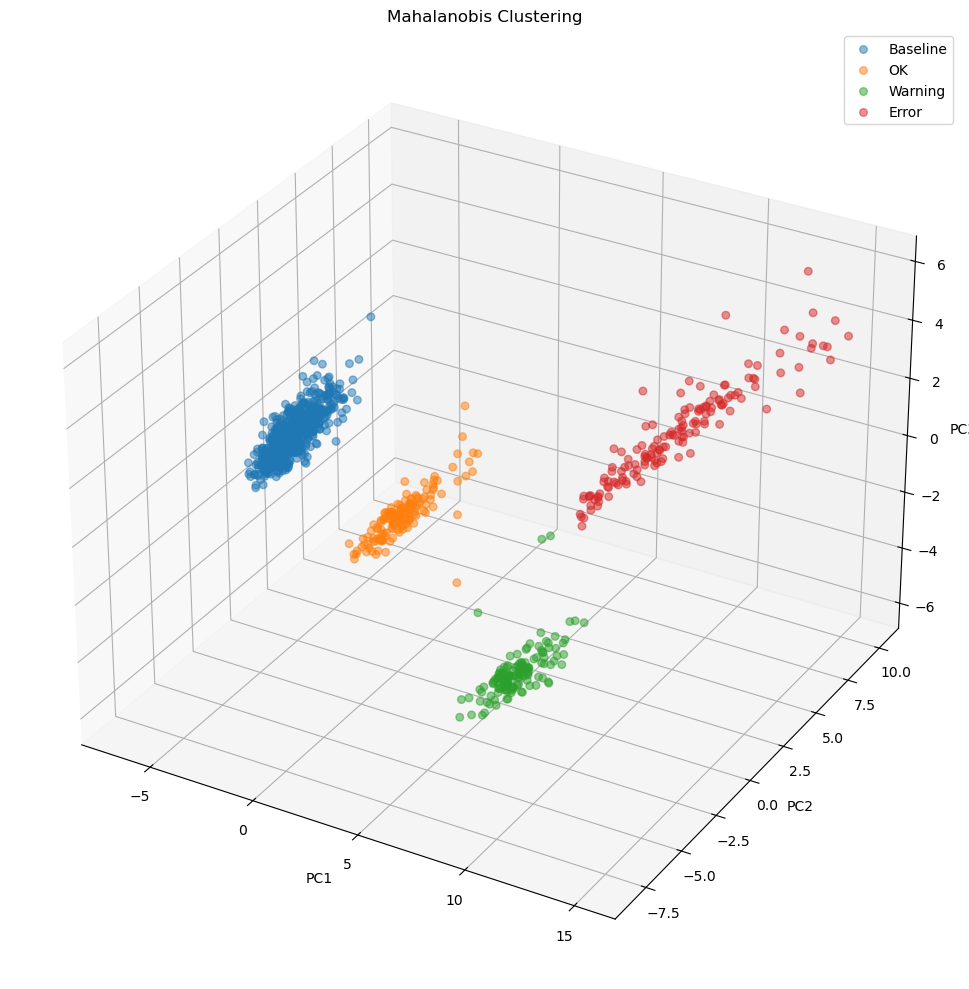

In [88]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
states = result['State'].unique()
for state in states:
    g = result[result['State'] == state]
    ax.scatter(g['PC1'], g['PC2'],g['PC3'], label = state, alpha = 0.5, s=30)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Mahalanobis Clustering")
ax.legend(loc='best')
plt.tight_layout()
plt.show()

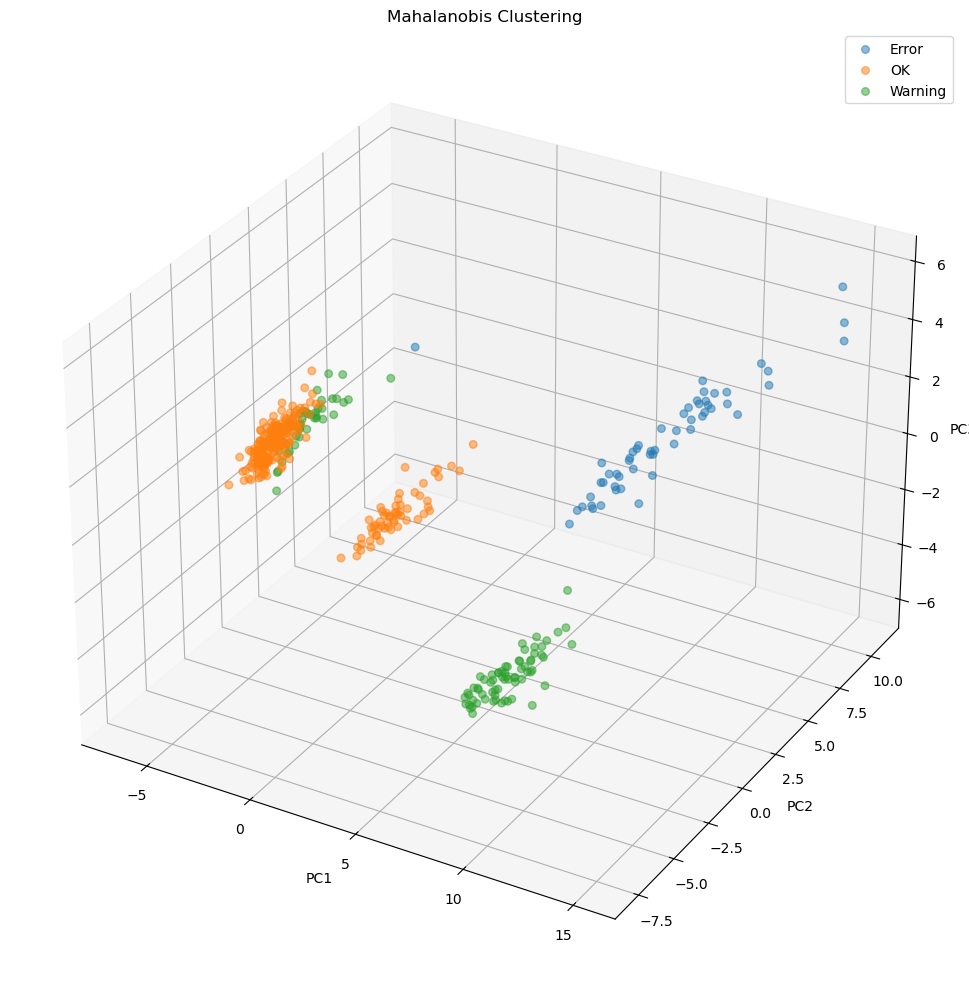

In [89]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
states = test_result['State'].unique()
for state in states:
    g = test_result[test_result['State'] == state]
    ax.scatter(g['PC1'], g['PC2'],g['PC3'], label = state, alpha = 0.5, s=30)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Mahalanobis Clustering")
ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [90]:
result.groupby("State").agg({"fault" : "mean"})

,fault
State,
Baseline,0.0
Error,1.0
OK,1.0
Warning,1.0


In [91]:
test_result.groupby("State").agg({"fault" : "mean"})

,fault
State,
Error,0.981818
OK,0.234818
Warning,0.607143


# Baseline only training

In [7]:
base_df = df_features[df_features['baseline'] == 1]

In [10]:
test_base = base_df.sample(200)
test_base

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
370,0.035059,6.140709,3.688571,-0.042189,0.346811,0.046663,0.017506,0.066747,2008.496935,348.772765,...,1065.0,19.016359,30.0,15.769520,1035.0,14.750318,1040.0,9.787331,1,0
194,0.034416,5.509260,3.315103,-0.055899,0.346811,0.045657,0.016471,0.063857,2002.121988,363.214913,...,1065.0,18.516064,1035.0,16.888466,30.0,10.802590,55.0,8.907529,1,0
391,0.032243,2.479937,1.771539,0.010939,0.349312,0.044436,0.009971,0.060997,2074.653773,233.782077,...,1065.0,15.829836,1035.0,15.688702,30.0,11.314162,1010.0,9.914815,1,0
13,0.033963,4.232846,2.296500,0.003707,0.346811,0.045633,0.013589,0.066500,2039.131452,291.450658,...,1065.0,17.503057,1035.0,15.609935,1095.0,9.628428,30.0,9.128241,1,0
360,0.036272,4.676923,3.434419,0.094555,0.343893,0.047571,0.019562,0.076769,1959.792636,415.961362,...,30.0,20.896705,1065.0,15.928976,1035.0,14.770319,55.0,10.853213,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,0.033781,3.940778,2.399516,0.053197,0.345561,0.045654,0.014319,0.064681,2009.446035,346.499192,...,1065.0,18.181641,1035.0,12.988174,30.0,10.522533,1095.0,8.971068,1,0
118,0.033945,5.652490,2.933967,-0.019029,0.345977,0.045825,0.015059,0.064628,2020.544772,333.260588,...,1035.0,17.832652,1065.0,17.533179,30.0,11.613719,55.0,11.066299,1,0
297,0.033662,3.738485,2.172272,0.033330,0.347645,0.045893,0.013160,0.064212,2042.595867,288.960066,...,1065.0,17.051120,30.0,15.197472,1035.0,15.154252,1040.0,9.085940,1,0
218,0.032172,3.222294,1.825958,0.004470,0.350146,0.044164,0.010544,0.061184,2078.851402,214.838349,...,30.0,15.739550,1065.0,15.588788,1035.0,15.527182,1040.0,9.908427,1,0


In [11]:
train_df = base_df.drop(test_base.index)
train_df

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
527,0.033017,4.489761,2.636303,0.068072,0.348062,0.043732,0.012035,0.062299,2062.172854,263.806909,...,1035.0,16.044784,1065.0,14.853492,30.0,12.617569,1040.0,10.406439,1,0
670,0.032560,3.145893,1.912368,-0.001784,0.349729,0.044530,0.011640,0.063002,2063.379722,245.216119,...,1035.0,17.985210,1065.0,16.691442,30.0,9.396658,60.0,7.916228,1,0
82,0.034201,4.445558,2.541771,0.014233,0.345561,0.045748,0.014847,0.066036,2016.236809,336.992665,...,1035.0,19.202496,1065.0,13.731582,1040.0,10.779253,30.0,8.782284,1,0
638,0.037555,4.680702,4.315767,0.212303,0.341809,0.047549,0.022092,0.072347,1949.631794,424.440318,...,1065.0,15.602069,1035.0,15.321215,30.0,15.275979,20.0,10.826901,1,0
70,0.034486,4.379982,2.878847,0.135444,0.346811,0.046087,0.016072,0.065742,2014.486397,334.417604,...,30.0,18.930534,1065.0,17.766038,1035.0,17.332736,200.0,9.193443,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.033945,4.280669,2.470035,0.068637,0.345561,0.045661,0.014552,0.064836,2005.085715,353.188886,...,1035.0,16.405780,1065.0,12.335831,1040.0,8.280545,1410.0,7.988016,1,0
238,0.032059,2.683514,1.822136,-0.009609,0.350146,0.044278,0.010651,0.062784,2080.093140,205.893863,...,1065.0,20.144011,1035.0,15.349547,25.0,9.572159,30.0,9.549815,1,0
484,0.033027,3.642774,2.061069,0.052181,0.348062,0.044930,0.012539,0.064213,2042.671980,285.146357,...,1035.0,17.834615,1065.0,13.313698,30.0,13.181906,1045.0,8.222124,1,0
558,0.033403,3.567575,2.267287,0.035587,0.346811,0.045396,0.013373,0.064319,2033.748011,305.819357,...,1035.0,17.186193,1065.0,16.964310,30.0,14.849203,1010.0,8.836427,1,0


In [13]:
f_cols = train_df.columns[:-2]

In [24]:
cfg = admc.PCAMahalanobisConfig(
        n_components=3,      # auto-select k to reach var_target
        var_target=0.95,
        standardize=True,
        robust=True,            # MinCovDet for baseline covariance
        q_ok=0.90,
        q_warn=0.99,
        baseline_col="baseline",
        baseline_value=1,
        cluster_mode = 'kmeans',
        kmeans_space = 'scores',
        feature_cols=f_cols       # infer numeric columns except 'label'; or pass an explicit list
    )

clf = admc.PCAMahalanobisClassifier(cfg)
result = clf.fit(train_df)

# 'result' includes PC scores, md2 (squared Mahalanobis), md, and 'State' in {"Baseline","OK","Warning","Error"}.
# Example:
print(clf.thresholds())     # (t_ok, t_warn) on chi-square d^2 scale
#print(result[["md2","State"]].head())

# If you need the PCA loadings:
loadings = clf.components_()

(None, None)


In [25]:
loadings

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak1_freq,env_peak1_amp,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp
PC1,-0.004066,-0.010913,-0.027502,0.002155,-0.016371,0.000986,-0.012690,0.014557,-0.006137,0.003612,...,-0.0,-0.105406,0.055137,-0.001915,0.028440,-0.008082,-0.013710,-0.045741,0.034297,-0.062856
PC2,0.302437,0.189017,0.200483,0.128195,-0.273202,0.273895,0.296009,0.265388,-0.302216,0.298311,...,0.0,0.092878,-0.061198,-0.031131,-0.033708,-0.014538,0.029142,0.060317,-0.032207,0.017189
PC3,-0.006824,0.027156,0.019975,-0.008668,0.006964,-0.012396,0.002944,-0.019863,0.007019,-0.007668,...,-0.0,0.254510,-0.076090,0.151919,-0.030628,0.142089,0.010936,0.141972,-0.065916,0.099817


In [20]:
test_df = pd.concat((test_base, df_features[df_features['baseline'] == 0])).sample(frac = 1)
test_df

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
564,0.032561,3.000127,1.912738,-0.007547,0.347645,0.044743,0.011404,0.062969,2055.967216,269.950296,...,1035.0,17.301299,1065.0,17.231841,30.0,11.411245,1040.0,8.772240,1,0
588,0.033364,3.658511,2.273663,0.072815,0.345144,0.045118,0.013596,0.064455,2016.480562,342.009147,...,1065.0,18.287663,1035.0,16.302132,30.0,13.665031,1095.0,8.516934,1,0
234,0.032354,2.699256,1.783940,0.004540,0.349312,0.044694,0.010160,0.061742,2075.262439,217.807530,...,1065.0,17.028545,1035.0,16.676715,30.0,10.601343,25.0,7.587388,1,0
777,0.032397,2.999435,1.884215,0.001198,0.348479,0.044546,0.011173,0.062421,2061.627108,243.970947,...,1065.0,17.840778,1035.0,15.108024,1095.0,10.144844,1040.0,9.388980,1,0
120,0.034070,4.085399,2.428532,0.094465,0.347228,0.046068,0.014740,0.066933,2018.779089,334.215960,...,1035.0,16.424842,30.0,15.236604,1065.0,14.599900,1040.0,8.270693,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1338,0.794126,3.952781,4.078042,0.009556,0.448937,0.952982,0.607743,2.233086,2691.533237,202.919017,...,105.0,480.846936,150.0,317.950860,205.0,293.083343,115.0,285.049840,0,1
1299,0.787506,4.192798,4.147124,-0.004732,0.452272,0.939510,0.580594,2.181765,2695.810163,199.028909,...,105.0,431.608086,150.0,318.095092,205.0,291.131716,210.0,233.367756,0,1
1075,0.242152,4.505912,6.941662,-0.006618,0.557732,0.252821,0.215830,0.719578,3295.313984,329.190828,...,105.0,160.863981,45.0,110.865153,60.0,92.222197,30.0,86.370961,0,1
347,0.033771,4.889926,2.549435,0.038887,0.347645,0.045707,0.013577,0.062869,2043.315632,289.957426,...,1035.0,17.299420,1065.0,12.652349,1040.0,9.136913,1095.0,7.807779,1,0


In [21]:
test_df['fault'].mean()

0.7524752475247525

In [22]:
res = clf.transform(test_df)
res["State"] = clf.predict(test_df)

TypeError: '<=' not supported between instances of 'float' and 'NoneType'

# Updated Code

In [6]:
df_features

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
501,0.033011,2.905078,1.857814,-0.007154,0.349729,0.045337,0.011424,0.063278,2065.993850,235.385031,...,1035.0,18.219937,1065.0,17.217719,30.0,9.210088,1010.0,9.071178,1,0
275,0.032007,2.492539,1.830069,-0.004826,0.350563,0.043819,0.010530,0.062085,2076.642239,213.427594,...,1035.0,17.703634,1065.0,13.134676,30.0,10.280095,1095.0,9.204026,1,0
1257,0.764305,3.780786,4.071670,0.013447,0.454356,0.932694,0.577343,2.177801,2699.331599,197.269328,...,105.0,407.110810,205.0,303.584228,150.0,287.446766,100.0,215.533162,0,1
643,0.032907,3.562593,1.963809,0.025630,0.347228,0.044987,0.011877,0.063124,2050.896196,262.818142,...,1065.0,18.441579,1035.0,17.588972,30.0,13.516113,1010.0,9.145009,1,0
1014,0.258086,6.320653,8.010633,0.003364,0.557732,0.263278,0.244284,0.837157,3296.664993,354.543105,...,105.0,168.717515,45.0,139.257043,205.0,98.672320,310.0,82.749454,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0.032397,2.999435,1.884215,0.001198,0.348479,0.044546,0.011173,0.062421,2061.627108,243.970947,...,1065.0,17.840778,1035.0,15.108024,1095.0,10.144844,1040.0,9.388980,1,0
41,0.034516,4.169743,2.666729,0.118872,0.345977,0.046084,0.015756,0.066882,2006.191930,348.414080,...,1035.0,15.069014,30.0,12.429114,1065.0,11.564506,25.0,8.155728,1,0
769,0.031874,2.834727,1.820705,0.014103,0.348895,0.043704,0.010062,0.058836,2071.406248,254.307920,...,1035.0,16.097540,1065.0,12.718206,1040.0,11.560118,30.0,10.177872,1,0
127,0.032031,2.777817,1.780530,0.000393,0.350146,0.044131,0.010022,0.060197,2084.497179,195.859449,...,1035.0,17.839027,1065.0,15.165054,30.0,7.971999,1010.0,7.938511,1,0


In [9]:
baseline_df = df_features[df_features['baseline'] == 1]
test_base = baseline_df.sample(200)
baseline_df = baseline_df.drop(test_base.index)
test_base

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
543,0.032409,3.936038,1.913277,-0.028600,0.350563,0.044507,0.010632,0.062551,2078.526384,209.601758,...,1035.0,16.508694,1065.0,14.732006,30.0,12.294203,1040.0,12.058245,1,0
348,0.034860,4.737114,3.003200,0.090333,0.347228,0.045808,0.015398,0.064341,2021.832300,324.153960,...,1035.0,18.658122,1065.0,13.685092,30.0,13.633723,1040.0,9.768536,1,0
452,0.032908,4.723866,2.421065,-0.008996,0.346811,0.044446,0.013426,0.062842,2034.610836,308.423096,...,30.0,17.865510,1065.0,16.931907,1035.0,14.470947,55.0,10.091948,1,0
175,0.033980,5.458577,2.393060,0.123494,0.346811,0.046167,0.011644,0.065181,2043.722447,288.053298,...,1035.0,17.097351,1065.0,15.980865,30.0,10.367581,230.0,9.634357,1,0
736,0.032227,2.290162,1.818923,-0.001372,0.350563,0.044217,0.010827,0.061889,2082.599680,199.550221,...,1035.0,17.550429,30.0,16.474128,1065.0,13.616339,1040.0,9.206670,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,0.033050,3.980716,2.171770,0.086066,0.348479,0.045246,0.012626,0.064172,2049.969709,275.386456,...,1065.0,19.480695,1035.0,16.288547,30.0,14.808633,1040.0,8.883110,1,0
742,0.034205,5.033855,3.033474,0.011680,0.347228,0.045934,0.015760,0.067243,2017.370033,323.120385,...,1065.0,19.132820,1035.0,14.955125,30.0,13.079460,1040.0,9.374631,1,0
276,0.032477,2.225526,1.808398,-0.012211,0.350146,0.044730,0.010570,0.063062,2075.416471,216.968093,...,1035.0,17.247020,1065.0,13.395422,30.0,11.152131,1040.0,10.109724,1,0
800,0.034553,4.693061,2.906298,0.187035,0.347228,0.046239,0.015700,0.065164,2029.429110,318.914573,...,30.0,15.713946,1065.0,15.486099,1035.0,14.714393,1410.0,9.142147,1,0


In [10]:
baseline_df

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
501,0.033011,2.905078,1.857814,-0.007154,0.349729,0.045337,0.011424,0.063278,2065.993850,235.385031,...,1035.0,18.219937,1065.0,17.217719,30.0,9.210088,1010.0,9.071178,1,0
275,0.032007,2.492539,1.830069,-0.004826,0.350563,0.043819,0.010530,0.062085,2076.642239,213.427594,...,1035.0,17.703634,1065.0,13.134676,30.0,10.280095,1095.0,9.204026,1,0
643,0.032907,3.562593,1.963809,0.025630,0.347228,0.044987,0.011877,0.063124,2050.896196,262.818142,...,1065.0,18.441579,1035.0,17.588972,30.0,13.516113,1010.0,9.145009,1,0
2,0.033945,3.601474,2.160996,0.052676,0.345561,0.045739,0.013577,0.066407,2022.455830,323.079776,...,1065.0,17.418492,1035.0,16.365837,30.0,12.249828,1040.0,9.631789,1,0
296,0.033620,4.776031,2.519462,0.005839,0.346394,0.045163,0.013987,0.065608,2023.373108,329.940485,...,1035.0,15.780100,30.0,15.602912,1065.0,15.205369,1040.0,9.888622,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0.032397,2.999435,1.884215,0.001198,0.348479,0.044546,0.011173,0.062421,2061.627108,243.970947,...,1065.0,17.840778,1035.0,15.108024,1095.0,10.144844,1040.0,9.388980,1,0
41,0.034516,4.169743,2.666729,0.118872,0.345977,0.046084,0.015756,0.066882,2006.191930,348.414080,...,1035.0,15.069014,30.0,12.429114,1065.0,11.564506,25.0,8.155728,1,0
769,0.031874,2.834727,1.820705,0.014103,0.348895,0.043704,0.010062,0.058836,2071.406248,254.307920,...,1035.0,16.097540,1065.0,12.718206,1040.0,11.560118,30.0,10.177872,1,0
127,0.032031,2.777817,1.780530,0.000393,0.350146,0.044131,0.010022,0.060197,2084.497179,195.859449,...,1035.0,17.839027,1065.0,15.165054,30.0,7.971999,1010.0,7.938511,1,0


In [11]:
df_new = pd.concat((df_features[df_features['baseline'] == 0], test_base)).sample(frac=1)
df_new

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
1106,0.252377,5.973646,8.279367,0.035791,0.558983,0.253391,0.249004,0.812978,3290.897497,343.662756,...,105.0,166.715554,45.0,134.686084,60.0,84.032018,55.0,83.603242,0,1
1087,0.248729,5.800791,8.648965,0.016853,0.556482,0.263092,0.244241,0.802867,3294.813588,338.864962,...,105.0,157.138421,45.0,110.955685,65.0,85.696343,310.0,84.929749,0,1
1002,0.579873,4.242341,7.004239,0.002254,0.547728,0.562588,0.602253,1.908759,3246.297822,430.236254,...,105.0,554.329623,205.0,327.990291,310.0,308.895436,100.0,238.887121,0,1
225,0.033390,4.547897,2.608168,0.089319,0.348479,0.045227,0.013862,0.061923,2044.043338,287.773373,...,30.0,23.380601,1065.0,17.597649,1035.0,16.538133,1085.0,10.530082,1,0
1036,0.260532,5.722363,7.328937,-0.016735,0.551063,0.279103,0.250551,0.861667,3286.015867,334.825759,...,105.0,154.813741,60.0,135.443173,45.0,111.118569,310.0,98.952054,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,0.779631,3.991589,4.048422,0.005534,0.452272,0.939178,0.585361,2.186661,2696.119762,199.687560,...,105.0,439.048000,205.0,306.345691,150.0,300.608156,115.0,252.197632,0,1
1152,0.265224,5.000339,7.336703,0.006413,0.556065,0.279271,0.255359,0.864422,3305.497990,302.507251,...,105.0,167.186263,310.0,99.203517,45.0,98.331931,40.0,84.394753,0,1
1254,0.798378,3.543920,3.979685,-0.006595,0.452689,0.942633,0.591001,2.258524,2696.076691,198.048242,...,105.0,450.828056,150.0,301.794688,115.0,292.500957,205.0,292.369694,0,1
351,0.034087,3.861377,2.542069,0.070690,0.347645,0.046016,0.015168,0.064577,2020.695561,321.292748,...,1035.0,18.841440,1065.0,16.787267,30.0,13.194741,1095.0,9.333978,1,0


In [14]:
df_new['baseline'] = 0
df_new

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak2_freq,env_peak2_amp,env_peak3_freq,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault
1106,0.252377,5.973646,8.279367,0.035791,0.558983,0.253391,0.249004,0.812978,3290.897497,343.662756,...,105.0,166.715554,45.0,134.686084,60.0,84.032018,55.0,83.603242,0,1
1087,0.248729,5.800791,8.648965,0.016853,0.556482,0.263092,0.244241,0.802867,3294.813588,338.864962,...,105.0,157.138421,45.0,110.955685,65.0,85.696343,310.0,84.929749,0,1
1002,0.579873,4.242341,7.004239,0.002254,0.547728,0.562588,0.602253,1.908759,3246.297822,430.236254,...,105.0,554.329623,205.0,327.990291,310.0,308.895436,100.0,238.887121,0,1
225,0.033390,4.547897,2.608168,0.089319,0.348479,0.045227,0.013862,0.061923,2044.043338,287.773373,...,30.0,23.380601,1065.0,17.597649,1035.0,16.538133,1085.0,10.530082,0,0
1036,0.260532,5.722363,7.328937,-0.016735,0.551063,0.279103,0.250551,0.861667,3286.015867,334.825759,...,105.0,154.813741,60.0,135.443173,45.0,111.118569,310.0,98.952054,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,0.779631,3.991589,4.048422,0.005534,0.452272,0.939178,0.585361,2.186661,2696.119762,199.687560,...,105.0,439.048000,205.0,306.345691,150.0,300.608156,115.0,252.197632,0,1
1152,0.265224,5.000339,7.336703,0.006413,0.556065,0.279271,0.255359,0.864422,3305.497990,302.507251,...,105.0,167.186263,310.0,99.203517,45.0,98.331931,40.0,84.394753,0,1
1254,0.798378,3.543920,3.979685,-0.006595,0.452689,0.942633,0.591001,2.258524,2696.076691,198.048242,...,105.0,450.828056,150.0,301.794688,115.0,292.500957,205.0,292.369694,0,1
351,0.034087,3.861377,2.542069,0.070690,0.347645,0.046016,0.015168,0.064577,2020.695561,321.292748,...,1035.0,18.841440,1065.0,16.787267,30.0,13.194741,1095.0,9.333978,0,0


In [15]:
# 1) Configure classifier
cfg = admc.PCAMahalanobisConfig(
    n_components=3,          # or None for variance target
    var_target=0.95,
    standardize=True,
    robust=True,             # MinCovDet for baseline covariance
    q_ok=0.90,
    q_warn=0.99,
    baseline_col="baseline",
    baseline_value=1,
    feature_cols=None,       # infer numeric cols (excl. 'label')
    cluster_mode="threshold",# or "kmeans"
    kmeans_space="scores",
    random_state=0
)

clf = admc.PCAMahalanobisClassifier(cfg)

# 2) Fit ONLY on baseline
clf.fit(baseline_df)

# (Optional) Inspect thresholds
print("Thresholds (d^2):", clf.thresholds())

# 3) Score monitoring data
res_new = clf.transform(df_new)      # contains PC1..PCk, md2, md
res_new["State"] = clf.predict(df_new)
scored_new = df_new.join(res_new[["md2", "md", "State"]])
print(scored_new["State"].value_counts())

Thresholds (d^2): (6.251388631170325, 11.344866730144373)
State
Error      618
OK         162
Warning     28
Name: count, dtype: int64


In [17]:
scored_new.groupby("State").agg({'fault' : 'sum'})

,fault
State,
Error,608
OK,0
Warning,0


In [19]:
res_new

,PC1,PC2,PC3,md2,md,State
1106,-30.708445,423.664844,25.890879,2.662096e+04,163.159315,Error
1087,-37.717378,432.285072,19.934217,2.778125e+04,166.677077,Error
1002,-188.755690,1806.430321,-11.096950,4.859554e+05,697.105004,Error
225,-1.173104,-0.634658,7.270084,8.511047e+00,2.917370,Warning
1036,-43.518246,469.452758,17.526091,3.278620e+04,181.069607,Error
...,...,...,...,...,...,...
1227,-302.553013,3108.966795,-191.101728,1.443008e+06,1201.252540,Error
1152,-40.091498,475.191384,19.555452,3.352550e+04,183.099696,Error
1254,-308.151838,3152.634594,-192.973913,1.483937e+06,1218.169506,Error
351,2.270717,1.322862,3.564907,2.651538e+00,1.628354,OK


In [24]:
overall_res = pd.concat((scored_new, baseline_df), axis = 0)
overall_res

,imf1_rms,imf1_crest,imf1_kurt,imf1_skew,imf1_zcr,imf1_amp_mean,imf1_amp_std,imf1_amp_p95,imf1_f_mean,imf1_f_std,...,env_peak3_amp,env_peak4_freq,env_peak4_amp,env_peak5_freq,env_peak5_amp,baseline,fault,md2,md,State
1106,0.252377,5.973646,8.279367,0.035791,0.558983,0.253391,0.249004,0.812978,3290.897497,343.662756,...,134.686084,60.0,84.032018,55.0,83.603242,0,1,26620.962015,163.159315,Error
1087,0.248729,5.800791,8.648965,0.016853,0.556482,0.263092,0.244241,0.802867,3294.813588,338.864962,...,110.955685,65.0,85.696343,310.0,84.929749,0,1,27781.247903,166.677077,Error
1002,0.579873,4.242341,7.004239,0.002254,0.547728,0.562588,0.602253,1.908759,3246.297822,430.236254,...,327.990291,310.0,308.895436,100.0,238.887121,0,1,485955.386495,697.105004,Error
225,0.033390,4.547897,2.608168,0.089319,0.348479,0.045227,0.013862,0.061923,2044.043338,287.773373,...,17.597649,1035.0,16.538133,1085.0,10.530082,0,0,8.511047,2.917370,Warning
1036,0.260532,5.722363,7.328937,-0.016735,0.551063,0.279103,0.250551,0.861667,3286.015867,334.825759,...,135.443173,45.0,111.118569,310.0,98.952054,0,1,32786.202416,181.069607,Error
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,0.032397,2.999435,1.884215,0.001198,0.348479,0.044546,0.011173,0.062421,2061.627108,243.970947,...,15.108024,1095.0,10.144844,1040.0,9.388980,1,0,NaN,NaN,NaN
41,0.034516,4.169743,2.666729,0.118872,0.345977,0.046084,0.015756,0.066882,2006.191930,348.414080,...,12.429114,1065.0,11.564506,25.0,8.155728,1,0,NaN,NaN,NaN
769,0.031874,2.834727,1.820705,0.014103,0.348895,0.043704,0.010062,0.058836,2071.406248,254.307920,...,12.718206,1040.0,11.560118,30.0,10.177872,1,0,NaN,NaN,NaN
127,0.032031,2.777817,1.780530,0.000393,0.350146,0.044131,0.010022,0.060197,2084.497179,195.859449,...,15.165054,30.0,7.971999,1010.0,7.938511,1,0,NaN,NaN,NaN


In [26]:
overall_res['State'] = overall_res['State'].fillna('Baseline')

In [33]:
res_base = clf.transform(baseline_df)
res_base['State'] = 'Baseline'

In [34]:
res_base

,PC1,PC2,PC3,md2,md,State
501,-0.616140,-2.690768,-2.276073,1.424398,1.193481,Baseline
275,-1.339684,-6.086957,-3.495018,6.228875,2.495771,Baseline
643,0.920776,-3.439659,-3.020419,2.702121,1.643813,Baseline
2,-0.980942,2.202095,2.558295,2.300394,1.516705,Baseline
296,-2.897233,1.156013,-1.293612,1.534471,1.238738,Baseline
...,...,...,...,...,...,...
777,-0.729397,-2.754700,3.464843,2.773936,1.665514,Baseline
41,-2.165731,2.311255,-6.583080,8.023462,2.832572,Baseline
769,2.762181,-4.444808,2.577553,4.154146,2.038172,Baseline
127,6.381579,-5.522812,-2.139843,8.776554,2.962525,Baseline


In [35]:
res_new

,PC1,PC2,PC3,md2,md,State
1106,-30.708445,423.664844,25.890879,2.662096e+04,163.159315,Error
1087,-37.717378,432.285072,19.934217,2.778125e+04,166.677077,Error
1002,-188.755690,1806.430321,-11.096950,4.859554e+05,697.105004,Error
225,-1.173104,-0.634658,7.270084,8.511047e+00,2.917370,Warning
1036,-43.518246,469.452758,17.526091,3.278620e+04,181.069607,Error
...,...,...,...,...,...,...
1227,-302.553013,3108.966795,-191.101728,1.443008e+06,1201.252540,Error
1152,-40.091498,475.191384,19.555452,3.352550e+04,183.099696,Error
1254,-308.151838,3152.634594,-192.973913,1.483937e+06,1218.169506,Error
351,2.270717,1.322862,3.564907,2.651538e+00,1.628354,OK


In [36]:
results = pd.concat((res_base, res_new))
results

,PC1,PC2,PC3,md2,md,State
501,-0.616140,-2.690768,-2.276073,1.424398e+00,1.193481,Baseline
275,-1.339684,-6.086957,-3.495018,6.228875e+00,2.495771,Baseline
643,0.920776,-3.439659,-3.020419,2.702121e+00,1.643813,Baseline
2,-0.980942,2.202095,2.558295,2.300394e+00,1.516705,Baseline
296,-2.897233,1.156013,-1.293612,1.534471e+00,1.238738,Baseline
...,...,...,...,...,...,...
1227,-302.553013,3108.966795,-191.101728,1.443008e+06,1201.252540,Error
1152,-40.091498,475.191384,19.555452,3.352550e+04,183.099696,Error
1254,-308.151838,3152.634594,-192.973913,1.483937e+06,1218.169506,Error
351,2.270717,1.322862,3.564907,2.651538e+00,1.628354,OK


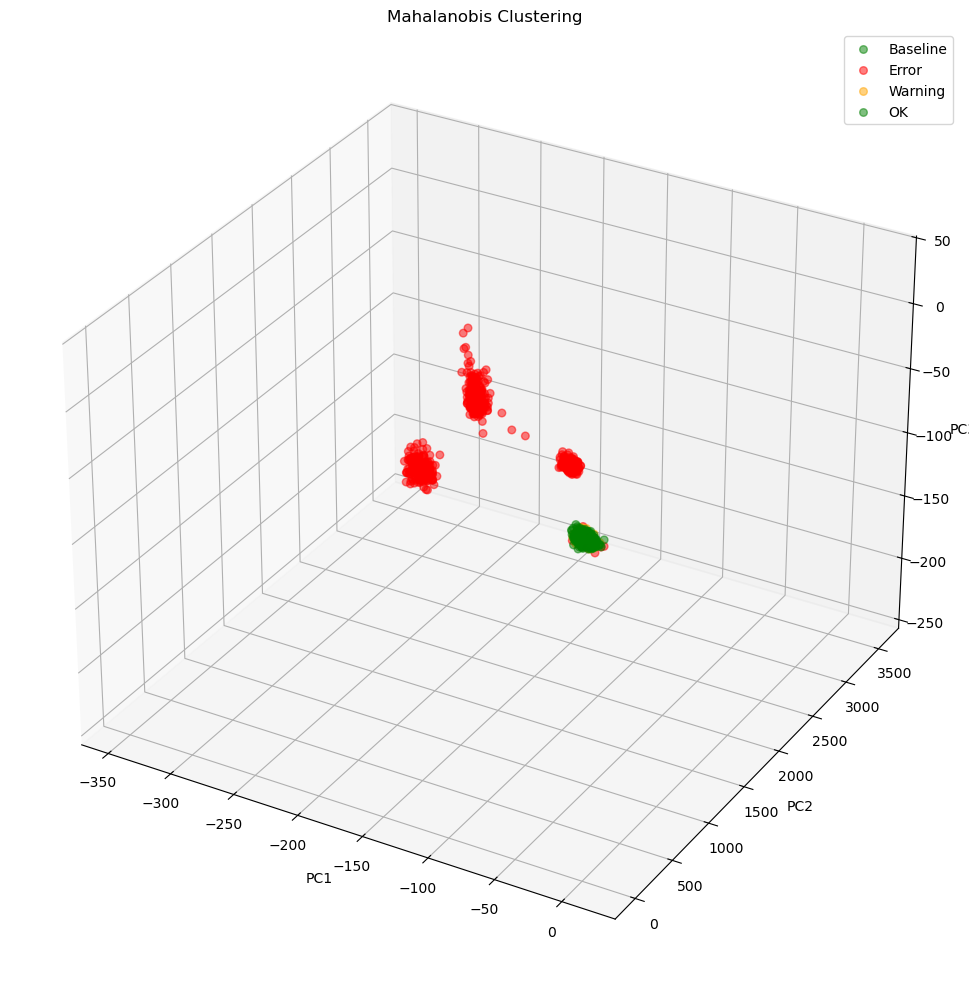

In [39]:
# Define color mapping
state_colors = {
    "Baseline": "green",
    "OK": "green",
    "Warning": "orange",
    "Error": "red"
}

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

states = results['State'].unique()
for state in states:
    g = results[results['State'] == state]
    ax.scatter(
        g['PC1'], g['PC2'], g['PC3'],
        label=state,
        alpha=0.5,
        s=30,
        color=state_colors.get(state, "gray")  # fallback gray if unknown
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Mahalanobis Clustering")
ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [44]:
scored_new.groupby('State').agg({'fault' : ['count','sum']})

fault     
        count  sum
State             
Error     618  608
OK        162    0
Warning    28    0